In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns

In [78]:
df = pd.read_csv("data/dataset_SCL.csv")

/home/enrique/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [79]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [80]:
#We transform the date column to datetime and set the day to 01
flight_dates = pd.to_datetime(df["Fecha-I"], format='%Y-%m-%d').dt.date
flight_dates_01 = flight_dates.apply(lambda dt: dt.replace(day=1))

Text(0, 0.5, 'Frequency')

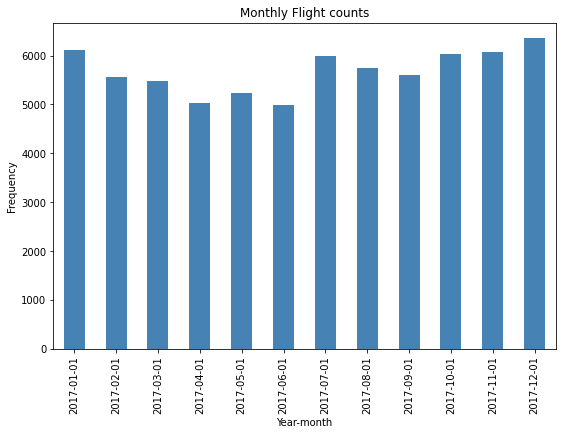

In [81]:
counts = flight_dates_01.value_counts().sort_index()
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
counts.plot.bar(ax = ax, color='steelblue')
ax.set_title('Monthly Flight counts')
ax.set_xlabel('Year-month')
ax.set_ylabel("Frequency")

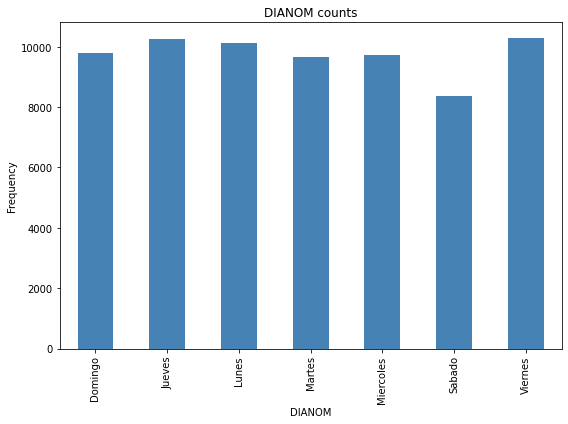

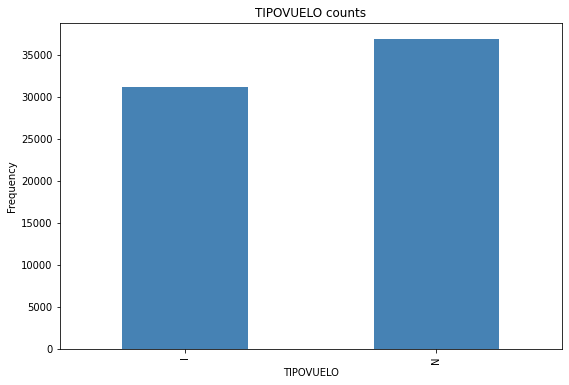

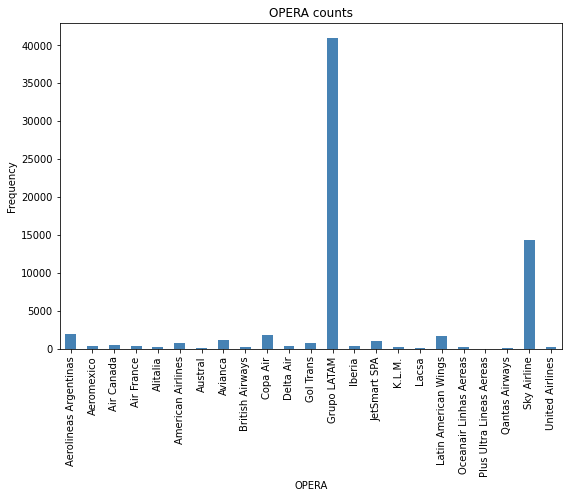

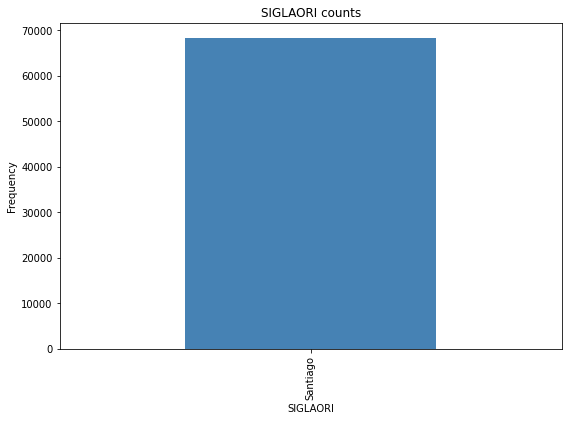

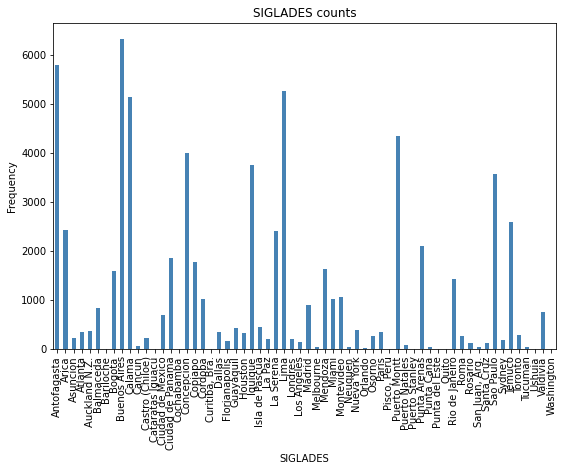

In [82]:
# plot a bar plot for each categorical feature count
categorical_features = ['DIANOM','TIPOVUELO','OPERA','SIGLAORI','SIGLADES']

for col in categorical_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()


In [83]:
temp_alta_1 = np.logical_or(flight_dates>=pd.datetime(2017,12,15).date(), flight_dates <=pd.datetime(2017,3,3).date())
temp_alta_2 = np.logical_and(pd.datetime(2017,7,1).date()<=flight_dates, flight_dates<=datetime(2017,7,31).date())
temp_alta_3 = np.logical_and(pd.datetime(2017,9,11).date()<=flight_dates, flight_dates<=pd.datetime(2017,9,30).date())
temp_alta = temp_alta_1 | temp_alta_2 |temp_alta_3

/tmp/ipykernel_109550/260999659.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  temp_alta_1 = np.logical_or(flight_dates>=pd.datetime(2017,12,15).date(), flight_dates <=pd.datetime(2017,3,3).date())
/tmp/ipykernel_109550/260999659.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  temp_alta_2 = np.logical_and(pd.datetime(2017,7,1).date()<=flight_dates, flight_dates<=datetime(2017,7,31).date())
/tmp/ipykernel_109550/260999659.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  temp_alta_3 = np.logical_and(pd.datetime(2017,9,11).date()<=flight_dates, flight_dates<=pd.datetime(2017,9,30).date())


In [84]:
fecha_I_datetime = pd.to_datetime(df["Fecha-I"], format='%Y-%m-%d')
fecha_O_datetime = pd.to_datetime(df["Fecha-O"], format='%Y-%m-%d')
dif_min = (fecha_O_datetime-fecha_I_datetime).astype('timedelta64[m]')

In [85]:
atraso_15 = dif_min > 15

In [86]:
synthetic_features_df = pd.DataFrame({"temp_alta" : temp_alta.astype(int), "dif_min" : dif_min, "atraso_15": atraso_15.astype(int)}) 

In [87]:
fecha_I_hour = fecha_I_datetime.dt.hour

In [88]:
synthetic_features_df.loc[(fecha_I_hour>=5) & (fecha_I_hour<=11), 'periodo_dia'] = 'mañana' 
synthetic_features_df.loc[(fecha_I_hour>=12) & (fecha_I_hour<=18), 'periodo_dia'] = 'tarde' 
synthetic_features_df.loc[(fecha_I_hour>=19) | (fecha_I_hour<=4), 'periodo_dia'] = 'noche' 

In [89]:
synthetic_features_df.head()

,temp_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,noche
1,1,9.0,0,noche
2,1,9.0,0,noche
3,1,3.0,0,noche
4,1,-2.0,0,noche


In [90]:
synthetic_features_df.to_csv("data/synthetic_features.csv")

In [91]:
df_final = pd.concat([df, synthetic_features_df], axis=1)

In [92]:
x, y = 'SIGLADES', 'atraso_15'

a = (df_final
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())

In [93]:
synthetic_features_df.loc[(fecha_I_hour>=5) & (fecha_I_hour<=11), 'periodo_dia'] = 'mañana' 
synthetic_features_df.loc[(fecha_I_hour>=12) & (fecha_I_hour<=18), 'periodo_dia'] = 'tarde' 

<Figure size 432x288 with 0 Axes>

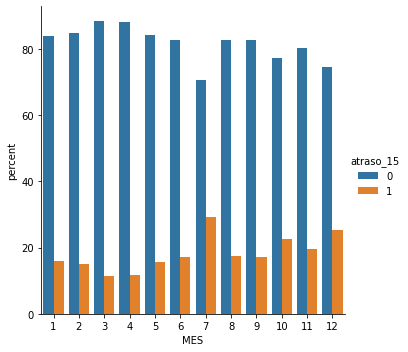

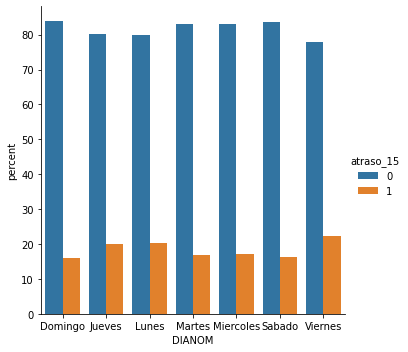

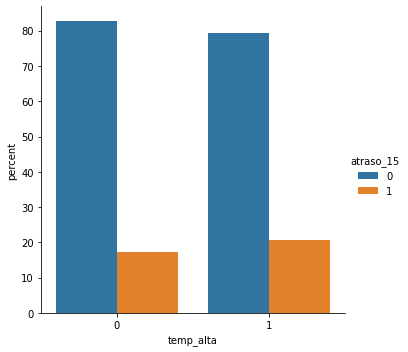

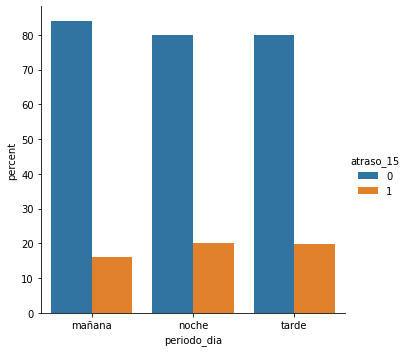

In [94]:
features = ['MES','DIANOM','temp_alta','periodo_dia']
for i,col in enumerate(features):
    plt.figure(i)
    x, y = col, 'atraso_15'
    delays_percentage = (df_final
                    .groupby(x)[y]
                    .value_counts(normalize=True)
                    .mul(100)
                    .rename('percent')
                    .reset_index())
    delays_percentage.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar')

In [95]:
top_10_counts_opera = df_final['OPERA'].value_counts()[:10].index.to_numpy()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Aerolineas Argentinas'),
  Text(1, 0, 'Air Canada'),
  Text(2, 0, 'American Airlines'),
  Text(3, 0, 'Avianca'),
  Text(4, 0, 'Copa Air'),
  Text(5, 0, 'Gol Trans'),
  Text(6, 0, 'Grupo LATAM'),
  Text(7, 0, 'JetSmart SPA'),
  Text(8, 0, 'Latin American Wings'),
  Text(9, 0, 'Sky Airline')])

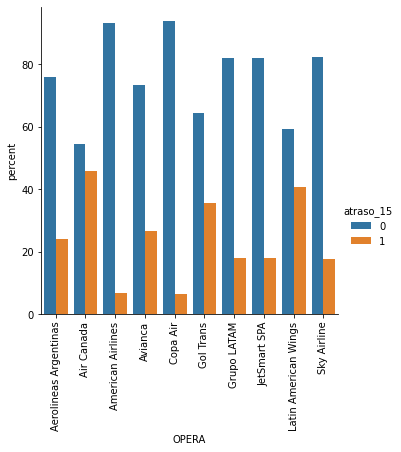

In [96]:
df_filter_opera = df_final.loc[df_final['OPERA'].isin(top_10_counts_opera)].reset_index()
x, y = 'OPERA', 'atraso_15'
delays_percentage = (df_filter_opera
                .groupby(x)[y]
                .value_counts(normalize=True)
                .mul(100)
                .rename('percent')
                .reset_index())
delays_percentage.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar')
plt.xticks(rotation=90)

In [97]:
top_10_counts_siglades = df_final['SIGLADES'].value_counts()[:15].index.to_numpy()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Antofagasta'),
  Text(1, 0, 'Arica'),
  Text(2, 0, 'Buenos Aires'),
  Text(3, 0, 'Calama'),
  Text(4, 0, 'Ciudad de Panama'),
  Text(5, 0, 'Concepcion'),
  Text(6, 0, 'Copiapo'),
  Text(7, 0, 'Iquique'),
  Text(8, 0, 'La Serena'),
  Text(9, 0, 'Lima'),
  Text(10, 0, 'Mendoza'),
  Text(11, 0, 'Puerto Montt'),
  Text(12, 0, 'Punta Arenas'),
  Text(13, 0, 'Sao Paulo'),
  Text(14, 0, 'Temuco')])

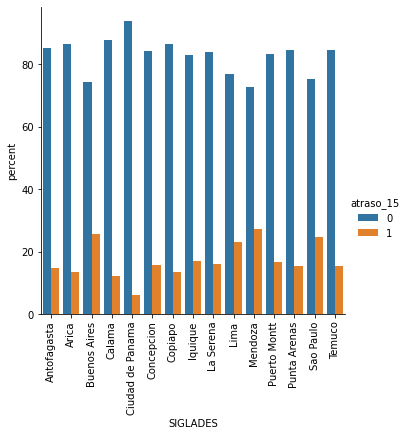

In [98]:
df_filter_siglades = df_final.loc[df_final['SIGLADES'].isin(top_10_counts_siglades)].reset_index()
x, y = 'SIGLADES', 'atraso_15'
delays_percentage = (df_filter_siglades
                .groupby(x)[y]
                .value_counts(normalize=True)
                .mul(100)
                .rename('percent')
                .reset_index())
delays_percentage.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar')
plt.xticks(rotation=90)

In [113]:
features = ['MES', 'SIGLADES', 'OPERA', 'temp_alta']
label = 'atraso_15'
X, y = df_final[features].values, df_final[label].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 47744
Test cases: 20462


In [114]:
X_train

array([[12, 'Miami', 'Grupo LATAM', 1],
       [2, 'Miami', 'Grupo LATAM', 1],
       [11, 'Buenos Aires', 'Grupo LATAM', 0],
       ...,
       [9, 'Antofagasta', 'Sky Airline', 0],
       [8, 'Arica', 'Grupo LATAM', 0],
       [8, 'Auckland N.Z.', 'Grupo LATAM', 0]], dtype=object)

In [115]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Set regularization rate
reg = 0.01

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [0, 1, 2, 3]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3])])),
                ('logregressor',
                 LogisticRegression(C=100.0, solver='liblinear'))])


Confusion Matrix:
 [[16523   127]
 [ 3655   157]] 

Accuracy: 0.815169582640993
Overall Precision: 0.5528169014084507
Overall Recall: 0.04118572927597062
AUC: 0.6639780572807856


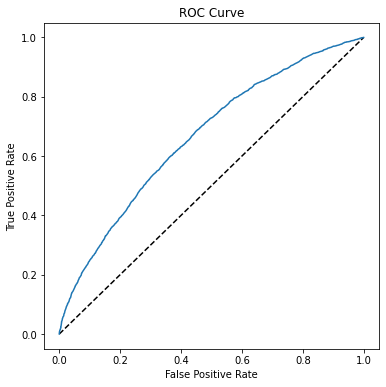

In [116]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

# Get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [117]:
from sklearn.ensemble import RandomForestClassifier

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier(n_estimators=100))])

# fit the pipeline to train a random forest model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3])])),
                ('logregressor', RandomForestClassifier())])


Confusion Matrix:
 [[16393   257]
 [ 3529   283]] 

Accuracy: 0.8149740983286091
Overall Precision: 0.524074074074074
Overall Recall: 0.0742392444910808

AUC: 0.6600144635716514


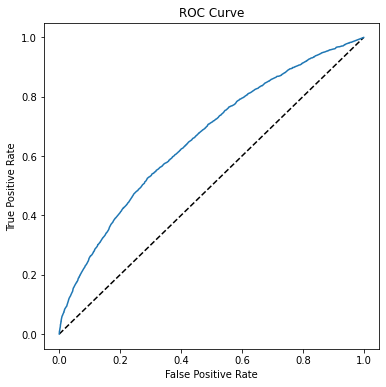

In [118]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()